# Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torchvision
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import os
from PIL import Image
import shutil
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.multiprocessing as mp
from tqdm import tqdm

mp.set_start_method('spawn', force=True)

# Helper Functions

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, fname))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # Since there are no labels, we can return a dummy label (0)

def create_subset_dataset(original_dir, subset_dir, subset_size=100):
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    
    image_paths = [os.path.join(original_dir, fname) for fname in os.listdir(original_dir) if os.path.isfile(os.path.join(original_dir, fname))]
    
    np.random.seed(1000)
    np.random.shuffle(image_paths)
    subset_paths = image_paths[:subset_size]
    
    for img_path in subset_paths:
        shutil.copy(img_path, subset_dir)

    print(f"Subset created with {len(subset_paths)} images in {subset_dir}")

def get_data_loader(data_dir, batch_size, image_size=(128, 128), subset_size=None):

    transform = transforms.Compose([
        transforms.Resize(image_size),
        #transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    assert os.path.exists(data_dir), f"Directory not found: {data_dir}"

    dataset = CustomImageDataset(root_dir=data_dir, transform=transform)

    if subset_size:
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)
        np.random.shuffle(indices)
        subset_indices = indices[:subset_size]
        subset_sampler = SubsetRandomSampler(subset_indices)
        loader = DataLoader(dataset, batch_size=batch_size, sampler=subset_sampler)
        return loader

    def split_indices(dataset):
        num_images = len(dataset)
        indices = list(range(num_images))
        np.random.seed(1000)
        np.random.shuffle(indices)

        train_split = int(0.7 * num_images)
        val_split = int(0.15 * num_images)

        train_indices = indices[:train_split]
        val_indices = indices[train_split:train_split + val_split]
        test_indices = indices[train_split + val_split:]

        return train_indices, val_indices, test_indices

    train_indices, val_indices, test_indices = split_indices(dataset)

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return train_loader, val_loader, test_loader

# Data Loading

### 1.1 Load Data

In [ ]:
BATCH_SIZE = 32

# Load data from the full datasets
train_loader_A, val_loader_A, test_loader_A = get_data_loader('/root/aps360-project/data/dataSetA_10k', BATCH_SIZE, image_size=(128, 128))
train_loader_B, val_loader_B, test_loader_B = get_data_loader('/root/aps360-project/data/dataSetB_10k', BATCH_SIZE, image_size=(128, 128))

# Landmarking

In [1]:
import cv2
import dlib
from matplotlib import pyplot as plt

In [2]:
frontalface_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

In [7]:
picture = '/home/alumkalryan/aps360-project/data/dataSetA_10k/000001.jpg'
#picture = '/home/alumkalryan/aps360-project/data/dataSetB_10k/36253_2011.jpg'
image = cv2.imread(picture)
#cv2.imshow('image', image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

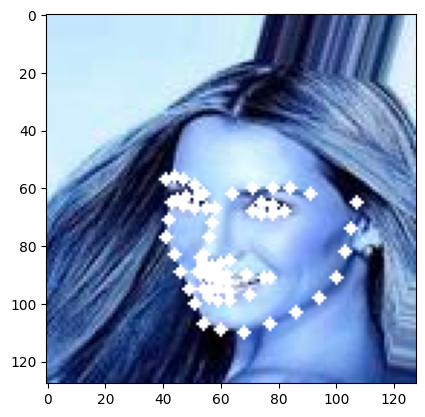

In [8]:
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray)

rects = frontalface_detector(img_gray, 1)

for (i, rect) in enumerate(rects):
    shape = landmark_predictor(img_gray, rect)
    shape = [(shape.part(i).x, shape.part(i).y) for i in range(68)]
    for (x, y) in shape:
        cv2.circle(image, (x, y), 2, (255, 255, 255), -1)
    plt.imshow(image)
    plt.show()